In [159]:
import torch
import numpy as np
from tqdm.auto import tqdm

from Dynamic import Dynamic
from Controller import Controller
from Env import Env
import matplotlib.pyplot as plt

In [160]:
dt = 0.1
H = 1000 # horizon
d_state = 2
d_action = 2

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 0, loss_train: 0.002447342115221545, loss_test: 0.0005481997816823423


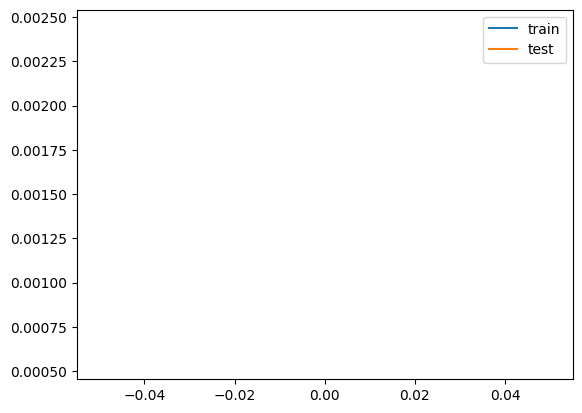

In [73]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = Env(torch.tensor([0, 0], dtype=torch.float32).unsqueeze(0), dt, H)
dynamic = Dynamic(d_state, d_action).to(device)
controller = Controller(d_state, d_action).to(device)

Dataset = []

# Phase 1: Pure exploration

num_episodes = 20000
# Generate random X_random with size num_episodes * d_state from uniform distribution
X_random = torch.rand(num_episodes, d_state) * 20 - 10

V_random = torch.rand(num_episodes, 1) * 4 - 2
theta_random = torch.rand(num_episodes, 1) * 2 * np.pi

#A_random = torch.cat([V_random, theta_random], dim=1)

randomized_time_vector = torch.rand(num_episodes, 1) * 1
randomized_time_vector = randomized_time_vector.to(device)

with torch.no_grad():
    A_random = controller(X_random.to(device), randomized_time_vector).cpu()

X_next = env.step(X_random, A_random)

Dataset = torch.cat([X_random, A_random, X_next], dim=1)

# train dynamic using Dataset

train_data, test_data = Dataset[:int(0.8 * num_episodes)], Dataset[int(0.8 * num_episodes):]

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

optimizer = torch.optim.Adam(dynamic.parameters(), lr=1e-3)



losses_train = []
losses_test = []

for epoch in tqdm (range(1)):
    loss_train = 0
    size_train = 0

    for i, data in enumerate(train_loader):
        X, A, X_next = data[:,:d_state], data[:,d_state:d_state+d_action], data[:,d_state+d_action:]
        X, A, X_next = X.to(device), A.to(device), X_next.to(device)

        optimizer.zero_grad()
        X_next_pred = dynamic(X, A)
        loss = torch.nn.functional.mse_loss(X_next_pred, X_next)
        loss.backward()
        optimizer.step()
        loss_train += loss.item()
        size_train += len(X)

    loss_test = 0
    size_test = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            X, A, X_next = data[:,:d_state], data[:,d_state:d_state+d_action], data[:,d_state+d_action:]
            X, A, X_next = X.to(device), A.to(device), X_next.to(device)
            X_next_pred = dynamic(X, A)
            loss = torch.nn.functional.mse_loss(X_next_pred, X_next)
            loss_test += loss.item()
            size_test += len(X)

    print(f"Epoch {epoch}, loss_train: {loss_train/size_train}, loss_test: {loss_test/size_test}")
    losses_train.append(loss_train/size_train)
    losses_test.append(loss_test/size_test)


plt.plot(losses_train, label="train")
plt.plot(losses_test, label="test")
plt.legend()
plt.show()


In [183]:

# torch.save(dynamic.state_dict(), "dynamic.pth")
# torch.save(controller.state_dict(), "controller.pth")

# load dynamic model
dynamic = Dynamic(d_state, d_action).to(device)
dynamic.load_state_dict(torch.load("dynamic.pth"))
dynamic.eval()
# 
# # load controller model
controller = Controller(d_state, d_action).to(device)
controller.load_state_dict(torch.load("controller.pth"))
controller.eval()


Controller(
  (fc1): Linear(in_features=3, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)

In [184]:
def evaluate_dynamic(dynamic, controller):
    # Checking compounding error
    
    num_episodes = 100000
    X0 = torch.rand(num_episodes, d_state) * 10
    X0 = X0.to(device)
    
    X_pred = X0
    X_oracle = X0
    
    episode_idx = 10
    X_preds = []
    X_oracles = []
    
    error = []
    
    with torch.no_grad():
        for t in range(H):
    
            X_preds.append(X_pred[episode_idx].cpu().numpy())
            X_oracles.append(X_oracle[episode_idx].cpu().numpy())
    
            vectorized_t = torch.ones(num_episodes, 1) * t / H
            vectorized_t = vectorized_t.to(device)
            A = controller(X_oracle, vectorized_t)
            
            X_oracle = env.step(X_oracle, A)
            X_pred = dynamic(X_pred, A)
                    
            error.append(torch.nn.functional.mse_loss(X_pred, X_oracle).item())
    
    plt.plot(error)
    plt.show()
    
    # plot both trajectories
    X_preds = np.array(X_preds)
    X_oracles = np.array(X_oracles)

    plt.plot(X_oracles[:,0], X_oracles[:,1], label="oracle")
    plt.plot(X_preds[:,0], X_preds[:,1], label="pred")
    # set x-axis and y-axis limits
    plt.xlim(-40, 40)
    plt.ylim(-40, 40)
    plt.legend()
    plt.show()
    
    print("trajectory error: ", np.mean(error), "last step error: ", error[-1])

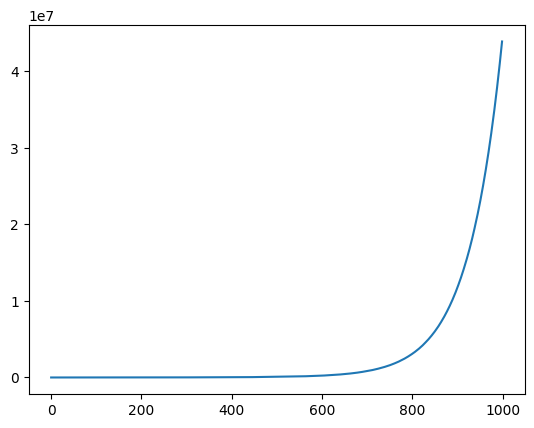

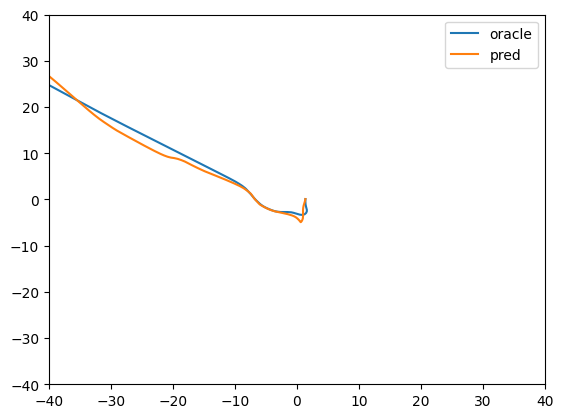

trajectory error:  3322029.738183173 last step error:  43864356.0


In [185]:
evaluate_dynamic(dynamic, controller)

In [186]:
def get_trajectory(dynamic, controller, X0, H):
    
    X0 = X0.to(device)
    
    X_pred = X0
    X_oracle = X0
    
    X_preds = []
    X_oracles = []
    
    with torch.no_grad():
        for t in range(H):
    
            X_preds.append(X_pred.cpu())
            X_oracles.append(X_oracle.cpu())
    
            vectorized_t = torch.ones(X0.shape[0], 1) * t / H
            vectorized_t = vectorized_t.to(device)
            A = controller(X_oracle, vectorized_t)
            
            X_oracle = env.step(X_oracle, A)
            X_pred = dynamic(X_pred, A)
    
    
    X_preds.append(X_pred.cpu())
    X_oracles.append(X_oracle.cpu())
    X_preds = torch.stack(X_preds, dim=1)
    X_oracles = torch.stack(X_oracles, dim=1)
    
    return X_oracles, X_preds

In [ ]:
# accumulate a trajectory and train the dynamic model using backpropagation through time
num_episodes = 64


optimizer = torch.optim.Adam(dynamic.parameters(), lr=1e-3)

N = 10 #H // rate  # trajectory sampling rate
rate = H // N

STRATEGIES = ["random_choice", "max-pick"]
STRATEGY = STRATEGIES[0]

for e in tqdm(range(10 * rate)):
    X0 = torch.rand(num_episodes, d_state) * 10
    X0 = X0.to(device)
    
    X_pred = X0
    X_oracle = X0    
    loss = 0
    
    
    if STRATEGY == "random_choice":
        t_samples = torch.randperm(H)[:N]
        t_samples = torch.sort(t_samples)[0]
    else:
        X_oracles, X_preds = get_trajectory(dynamic, controller, X0, H)
        # X_oracles shape: num_episodes * H * d_state
        # X_preds shape: num_episodes * H * d_state
        
        #find error at each time step
        error = torch.nn.functional.mse_loss(X_oracles, X_preds, reduction='none')
        error = torch.sum(error, dim=2)
        
        error = error[1:] - error[:-1]
        # error = error[:, 1:]
        
        error_max = torch.max(error.abs(), dim=0, keepdim=True)[0]        
        error = error / error_max
        
        
        
        
        # average error over all episodes
        error = torch.mean(error, dim=0)
        t_samples = torch.argsort(error, descending=True)[:N]
        t_samples = torch.sort(t_samples)[0]
        
    for t in range(H):
    
        vectorized_t = torch.ones(num_episodes, 1) * t / H
        vectorized_t = vectorized_t.to(device)
        A = controller(X_oracle, vectorized_t)
        
        X_oracle = env.step(X_oracle, A)
        
        if t in t_samples:
            X_pred = dynamic(X_pred, A)
            loss += torch.nn.functional.mse_loss(X_pred, X_oracle)
        else:
            with torch.no_grad():
                X_pred = dynamic(X_pred, A)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()    

  0%|          | 0/1000 [00:00<?, ?it/s]

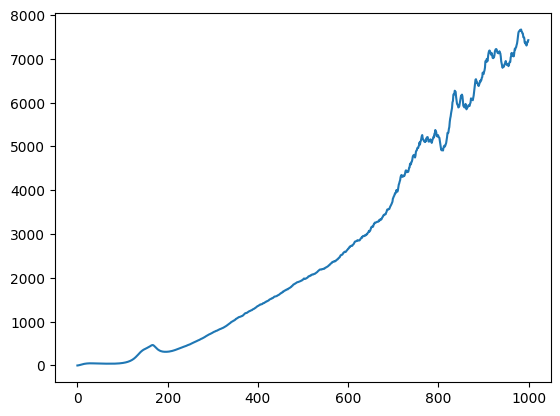

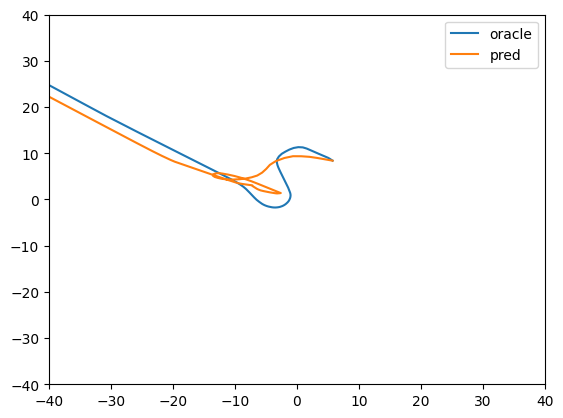

trajectory error:  2668.046507554382 last step error:  7426.55322265625


In [177]:
evaluate_dynamic(dynamic, controller)

In [149]:
t_samples

tensor([ 0, 20, 21, 22, 23, 24, 25, 26, 41, 42])